In [1]:
using OrdinaryDiffEq
using CairoMakie

In [2]:
# Check sign on dispersion relation
# Check the case with sigma_s = zeta = 0

In [3]:
function ψ(x, y, params)
    return @. 0.25 * ((params.σs + params.ζ) * x^2 - 2*x*y*params.σn + (params.ζ - params.σs)*y^2)
end

function u(x, y, t, params)
    return @. 0.5 * (params.σn * x + (params.σs - params.ζ) * y)
end

function v(x, y, t, params)
    return @. 0.5 * ((params.σs + params.ζ) * x - params.σn * y)
end

function ∂u∂x(x, y, t, params)
    return @. 0.5 * params.σn
end

function ∂u∂y(x, y, t, params)
    return @. 0.5 * (params.σs - params.ζ)
end

function ∂v∂x(x, y, t, params)
    return @. 0.5 * (params.σs + params.ζ)
end

function ∂v∂y(x, y, t, params)
    return @. -0.5 * params.σn
end

∂v∂y (generic function with 1 method)

In [102]:
function dispersion_relation(k1, k2, params)
    return sqrt.(params.f0^2 .+ params.gH*(k1.^2 + k2.^2))
end

function dxkdt!(dxk, xk, p, t)

    x = @views xk[:, 1]
    y = @views xk[:, 2]
    k = @views xk[:, 3]
    l = @views xk[:, 4]

    ω = dispersion_relation(k, l, p)
    Cg_x = @. p.gH * k / ω
    Cg_y = @. p.gH * l / ω

    dx = @views dxk[:, 1]
    dy = @views dxk[:, 2]
    dk = @views dxk[:, 3]
    dl = @views dxk[:, 4]

    u_packet = u(x, y, t, p)
    v_packet = v(x, y, t, p)
    ux = ∂u∂x(x, y, t, p)
    uy = ∂u∂y(x, y, t, p)
    vx = ∂v∂x(x, y, t, p)
    vy = ∂v∂y(x, y, t, p)
    
    dx .= u_packet + Cg_x
    dy .= v_packet + Cg_y
    
    dk .= @. -ux * k - vx * l
    dl .= @. -uy * k - vy * l
end

dxkdt! (generic function with 1 method)

In [174]:
ζ  = 0e-1
σn = 1e-1
σs = 0e-1
gH = 1e-1
f0 = 1.0
params = (; ζ, σn, σs, gH, f0) # Semi-colon to create a named tuple with current variable names
x = zeros(1)
y = zeros(1)
t = 0
vorticity = ∂v∂x(x, y, t, params) - ∂u∂y(x, y, t, params)
shear_strain = ∂v∂x(x, y, t, params) + ∂u∂y(x, y, t, params)
normal_strain = ∂u∂x(x, y, t, params) - ∂v∂y(x, y, t, params)
divergence = ∂u∂x(x, y, t, params) + ∂v∂y(x, y, t, params)
println("Divergence:    ", divergence)
println("Normal strain: ", normal_strain)
println("Shear strain:  ", shear_strain)
println("Vorticity:     ", vorticity)

Divergence:    0.0
Normal strain: 0.1
Shear strain:  0.0
Vorticity:     0.0


In [175]:
x0 = [-1, -1, -1,  -0.1,  -0.1,  0.1,  1,  1,  1]
y0 = [-1,  0,  1, -1,  0,  1, -1,  0,  1]
Npackets = length(x0)
range = (0:(Npackets-1)) / (Npackets - 1)
k0 = sin.(2π*range) .+ 1e-2
l0 = cos.(2π*range)
u0 = hcat(x0, y0, k0, l0)

prob = ODEProblem(dxkdt!, u0, (0.0f0, 150.0f0), params)

sol = solve(prob, ImplicitMidpoint(), dt = 0.005, reltol = 1e-8, abstol = 1e-8, saveat = 0.1);

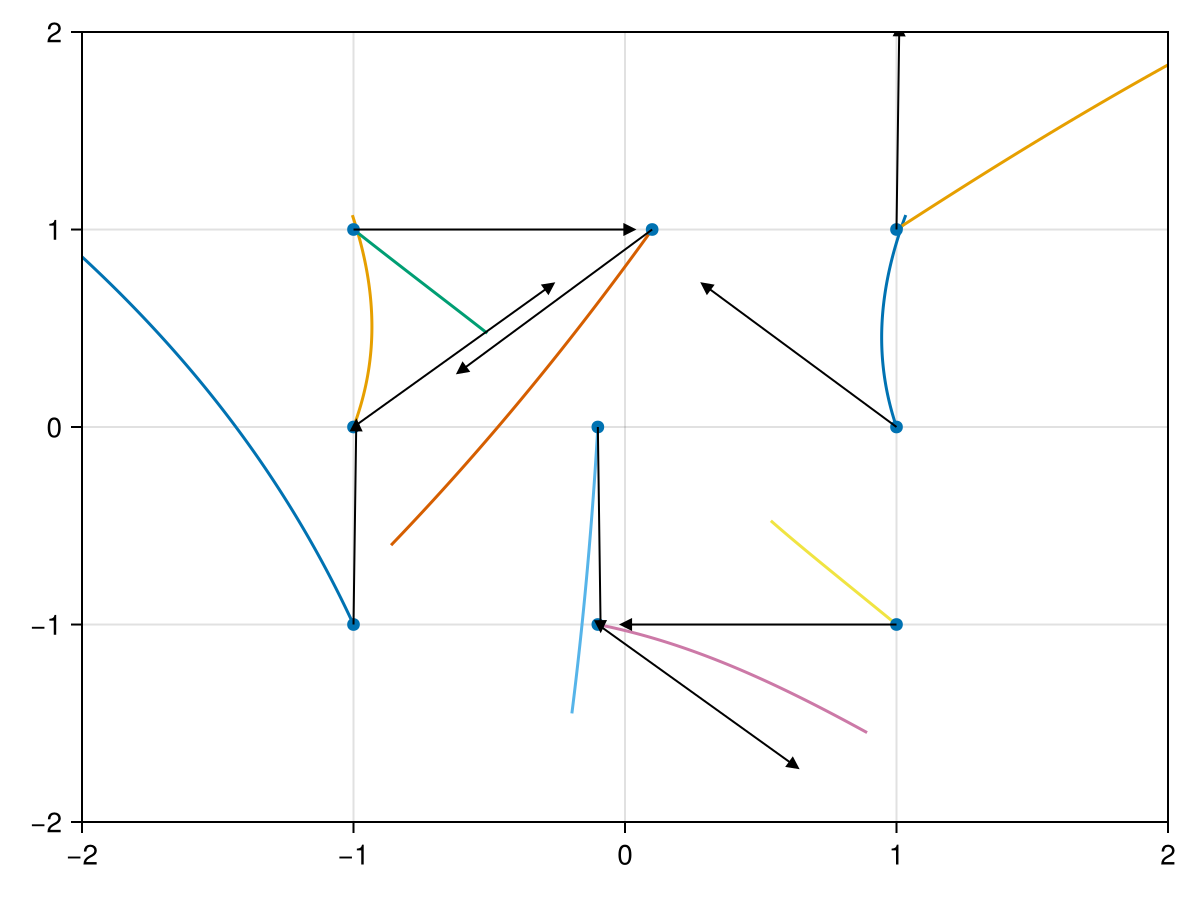

In [176]:
fig = Figure()
ax = Axis(fig[1,1], limits=((-2, 2), (-2, 2)))
for idx=1:9
    lines!(ax, sol[idx,1,1:150][:], sol[idx,2,1:150][:])
end
scatter!(ax, x0, y0)
arrows!(ax, x0, y0, k0, l0)
fig

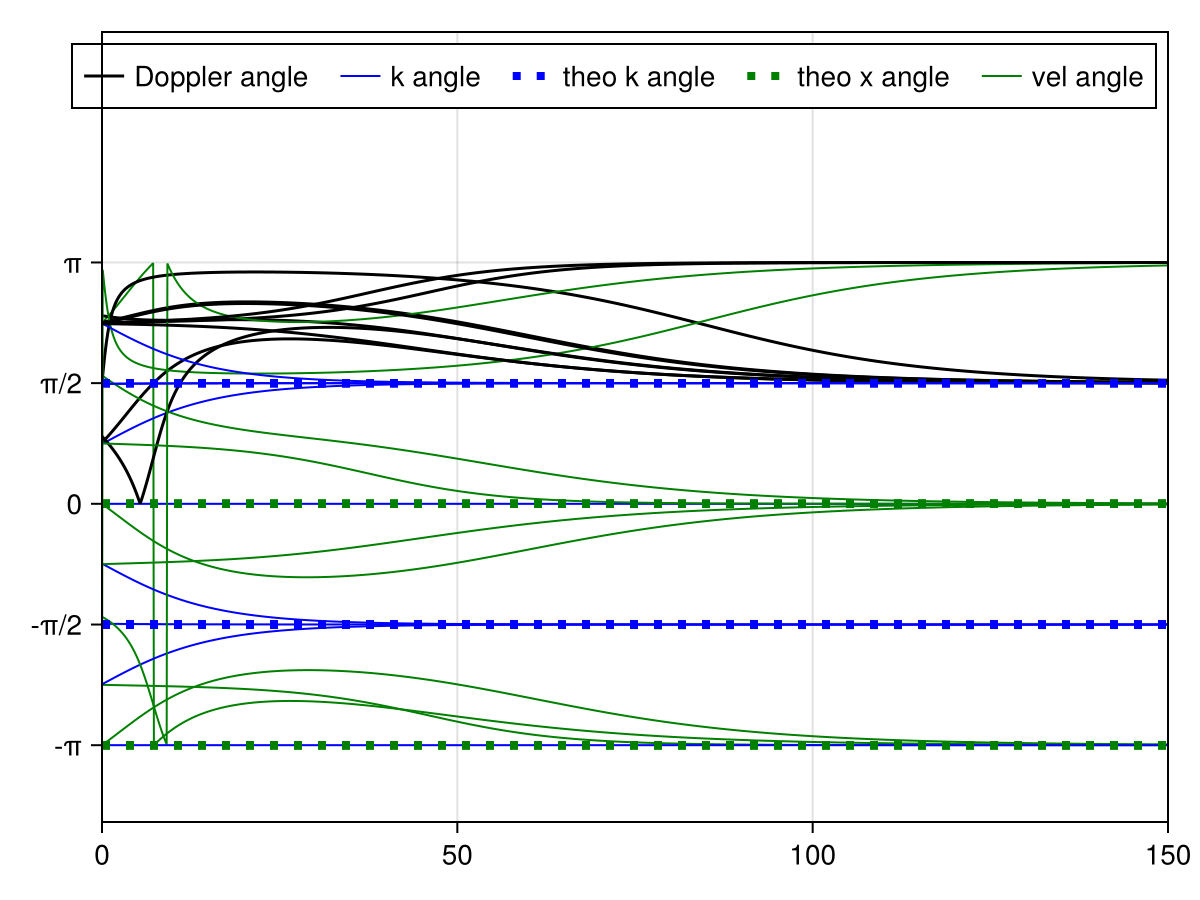

In [177]:
# l(t) component
#lines!(ax, sol.t, sol[4,:])
#lines!(sol.t, -U*sin.(α * sol.t)/α)
#pred_y = @. c/α * (asin(U*cos(α*sol.t)/(sqrt(α^2+U^2))) - asin(U/(sqrt(α^2+U^2))))
x_sol = sol[:,1,:]'
y_sol = sol[:,2,:]'
k_sol = sol[:,3,:]'
l_sol = sol[:,4,:]'
t_sol = sol.t
u_sol = u.(x_sol, y_sol, t_sol, Ref(params))
v_sol = v.(x_sol, y_sol, t_sol, Ref(params))

ω_sol = dispersion_relation.(k_sol, l_sol, Ref(params))
doppler_shift = u_sol .* k_sol + v_sol .* l_sol
wave_mag = sqrt.(l_sol.^2 + k_sol.^2)
vel_mag = sqrt.(u_sol.^2 + v_sol.^2)
dop_angle = acos.(min.(max.((doppler_shift ./ wave_mag ./ vel_mag), -1), 1))
wave_angle = atan.(l_sol, k_sol)
pos_angle = atan.(y_sol, x_sol)
vel_angle = atan.(v_sol, u_sol)
D = (σn^2 + σs^2 - ζ^2)/4

theo_wave_angle = atan(ζ-σs, -σn + 2*sqrt(D))
if(ζ == σs)
    if (σn != 0)
        theo_wave_angle = atan(1, -ζ/σn)
    else
        theo_wave_angle = atan(1, 0)
    end
end
theo_pos_angle = atan(1, -(-σn - 2*sqrt(D))/(ζ+σs))
if(ζ + σs == 0)
    theo_pos_angle = atan(0, 1)
end

theo_dop_angle = theo_pos_angle - theo_pos_angle


fig = Figure()
ax = Axis(fig[1,1]; limits=((0, sol.t[end]), (-π-1, π+3)),
    yticks=([-π, -π/2, 0, π/2, π], ["-π", "-π/2", "0", "π/2", "π"]))
for i=1:9
    lines!(ax, sol.t, dop_angle[:,i], color=:black, label="Doppler angle")
    lines!(ax, sol.t, wave_angle[:,i], color=:blue, linewidth=1, label="k angle")
    ablines!(ax, [theo_wave_angle, theo_wave_angle-π], [0, 0], color=:blue, linestyle=(:dot), linewidth=4, label="theo k angle")
    #lines!(ax, sol.t, pos_angle[:,i], color=:red, linewidth=1)
    ablines!(ax, [theo_pos_angle, theo_pos_angle-π], [0, 0], color=:green, linestyle=(:dot), linewidth=4, label="theo x angle")
    lines!(ax, sol.t, vel_angle[:,i], color=:green, linewidth=1,label="vel angle")
end
#lines!(ax, sol.t, doppler_shift)
#lines!(ax, sol.t, sol[3,:].^2 + sol[4,:].^2)
#lines!(ax, sol.t, sol[1,:])
axislegend(ax, merge = true, unique = true, position=:rt, orientation=:horizontal)
resize_to_layout!(fig)
fig

In [179]:
atan(1, 0)

1.5707963267948966

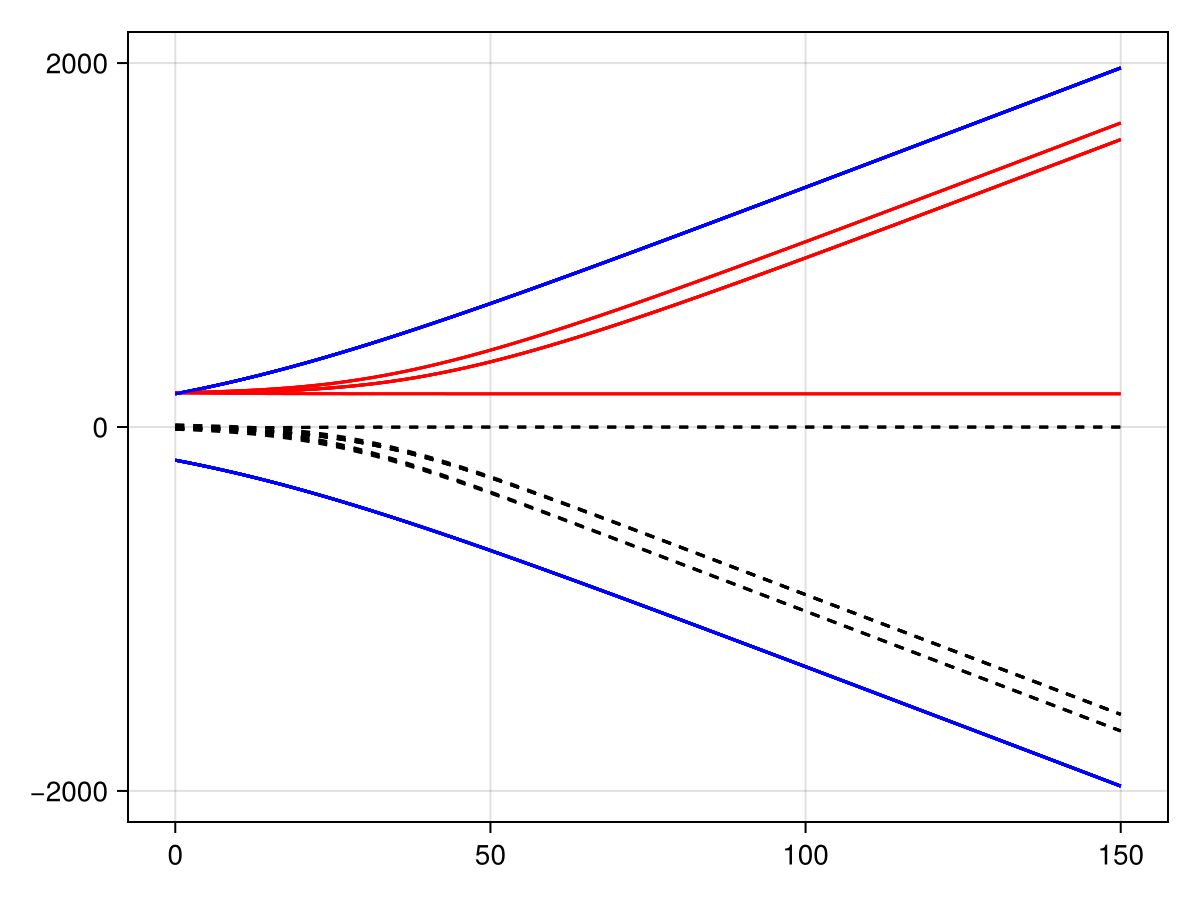

In [178]:
f2 = Figure()
ax = Axis(f2[1,1]; yscale=Makie.pseudolog10)
D = 0.5*sqrt.(σs^2 + σn^2 - ζ^2)
for i=1:9
    lines!(ax, sol.t, ω_sol[:,i], color=:red)
    lines!(ax, sol.t, doppler_shift[:,i], color=:black, linestyle=:dash)
    lines!(ax, sol.t, exp.(sol.t*D), color=:blue)
    lines!(ax, sol.t, -exp.(sol.t*D), color=:blue)
    #lines!(ax, sol.t, wave_mag[:,i] .* vel_mag[:,i], color=:green)
end

f2

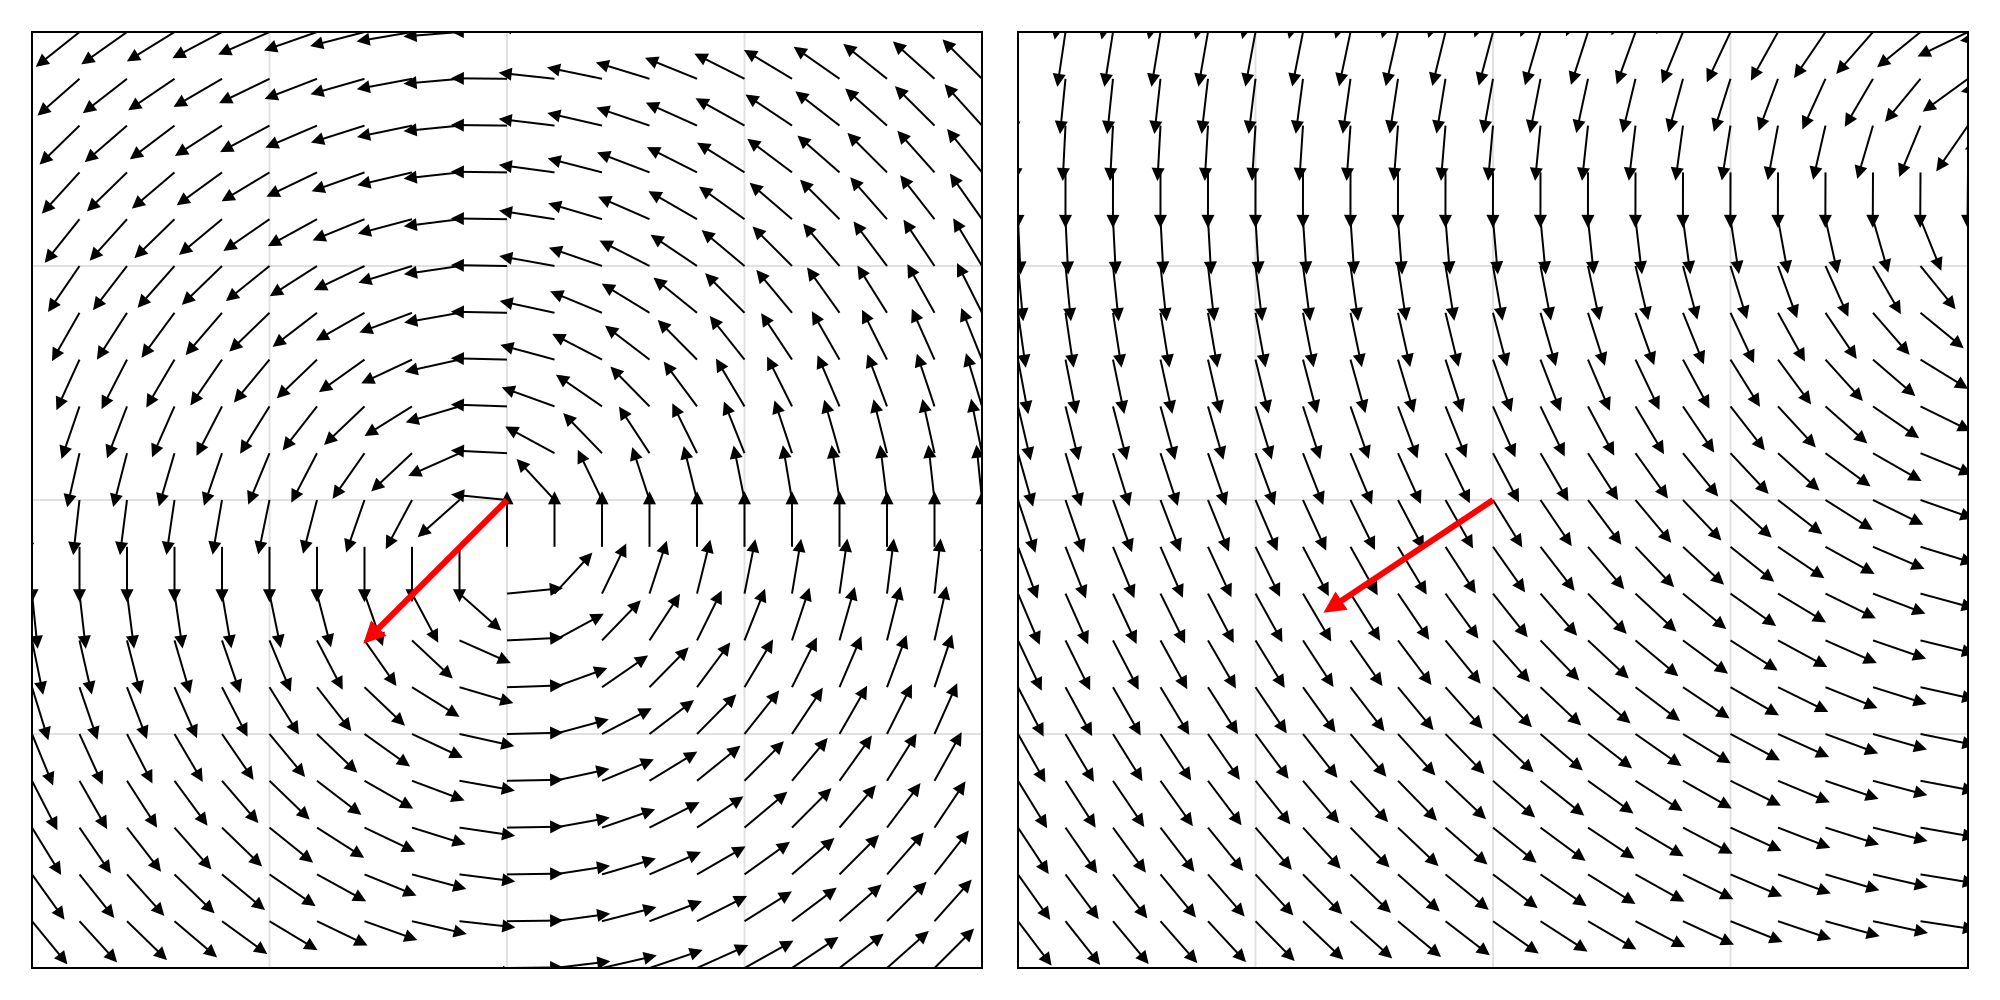

In [169]:
strain_viz_fig = Figure(size=(1000, 500))
ax_opts = (xticklabelsvisible=false, xticksvisible=false, yticklabelsvisible=false, yticksvisible=false, limits=((-10, 10), (-10, 10)))
start_ax = Axis(strain_viz_fig[1,1]; ax_opts...)
final_ax = Axis(strain_viz_fig[1,2]; ax_opts...)

packet_idx = 6
quiver_x = -11:11
quiver_y = (-11:11)'

function get_stats(t_idx, p_idx, x_offsets, y_offsets)
    t = t_sol[t_idx]
    x = x_sol[t_idx, packet_idx]
    y = y_sol[t_idx, packet_idx]
    k = k_sol[t_idx, packet_idx]
    l = l_sol[t_idx, packet_idx] 
    ψ_val = ψ.(x .+ x_offsets, y .+ y_offsets, Ref(params))
    u_val = u.(x .+ x_offsets, y .+ y_offsets, t, Ref(params))
    v_val = v.(x .+ x_offsets, y .+ y_offsets, t, Ref(params))
    return (t, x, y, k, l, u_val, v_val, ψ_val)
end

t0, x0, y0, k0, l0, u0, v0, ψ0 = get_stats(1, packet_idx, quiver_x, quiver_y)
tf, xf, yf, kf, lf, uf, vf, ψf = get_stats(length(t_sol), packet_idx, quiver_x, quiver_y)

arrows!(start_ax, quiver_x, quiver_y', u0, v0, lengthscale=1, normalize=true)
arrows!(start_ax, [0], [0], [k0], [l0], lengthscale=4, normalize=true, linewidth=3, color=:red, arrowsize=15)

arrows!(final_ax, quiver_x, quiver_y', uf, vf, lengthscale=1, normalize=true)
arrows!(final_ax, [0], [0], [kf], [lf], lengthscale=4, normalize=true, linewidth=3, color=:red, arrowsize=15)


strain_viz_fig

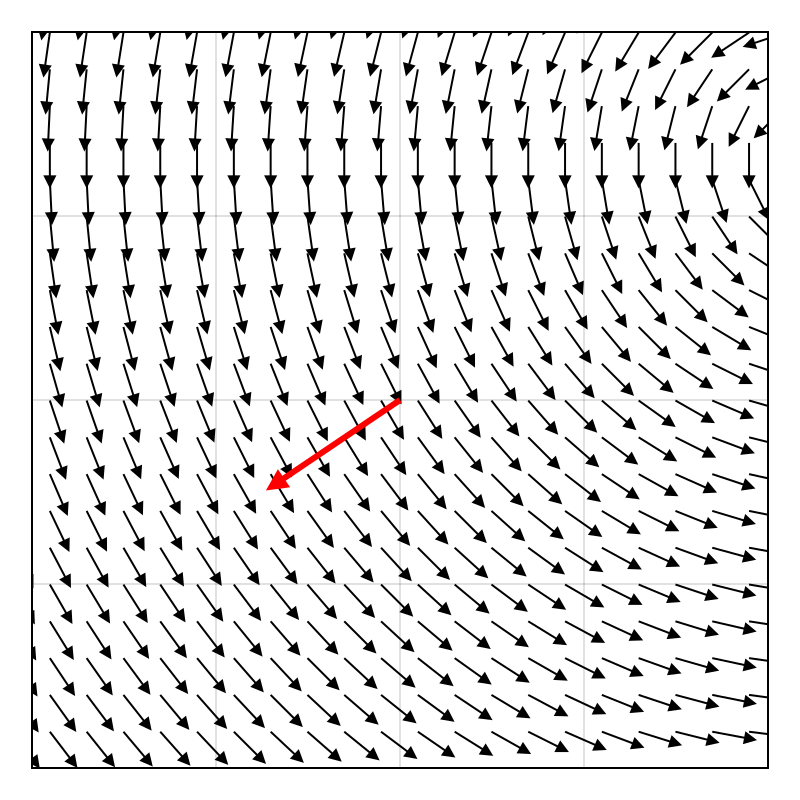

In [170]:
strain_movie = Figure(size=(400, 400))
ax_opts = (xticklabelsvisible=false, xticksvisible=false, yticklabelsvisible=false, yticksvisible=false, limits=((-10, 10), (-10, 10)))
ax = Axis(strain_movie[1,1]; ax_opts...)

delta = 1.0
quiver_x = -11:delta:11
quiver_y = (-11:delta:11)'

time_idx = Observable(1)    
results = @lift get_stats($time_idx, packet_idx, quiver_x, quiver_y)
t0 = @lift $results[1]
x0 = @lift $results[2]
y0 = @lift $results[3]
k0 = @lift $results[4]
l0 = @lift $results[5]
u0 = @lift $results[6]
v0 = @lift $results[7]
k_arrow = @lift [$k0]
l_arrow = @lift [$l0]
shift_x = @lift mod($x0, delta)
shift_y = @lift mod($y0, delta)
x_arrows = @lift quiver_x .- $shift_x
y_arrows = @lift quiver_y' .- $shift_y
results2 = @lift get_stats($time_idx, packet_idx, $x_arrows, $y_arrows')
u1 = @lift $results2[6]
v1 = @lift $results2[7]
arrows!(ax, x_arrows, y_arrows, u1, v1, lengthscale=1, normalize=true)
arrows!(ax, [0], [0], k_arrow, l_arrow, lengthscale=4, normalize=true, linewidth=3, color=:red, arrowsize=15)
record(strain_movie, "movies/arrow_animation.mp4", 1:5:(length(t_sol)); framerate = 12) do idx
    time_idx[] = idx
end
strain_movie